## Main figures for DG

We want to discuss the following simulations:
- High resolution
- 20 km no param
- 20 km ANN C = 0.5
- 20 km GM K = 200

The main thing we want to discuss are:
- Error in SSH
- Equlibrated KE and PE 
- APE reduction rates
- APE reduction cross-spectra

In [1]:
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from xgcm import Grid
from datatree import open_datatree, DataTree 

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2

In [2]:
import DG_sim_analysis_modules as sam

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load HR model
dir_HR = '/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR/'

ds_HR = {}
oce_geom = xr.open_dataset(dir_HR + 'ocean_geometry.nc')
oce_geom =oce_geom.rename({'lonh':'xh', 'lath':'yh', 'lonq':'xq', 'latq':'yq'})
ver_coord = xr.open_dataset(dir_HR + 'Vertical_coordinate.nc')
ver_coord = ver_coord.rename({'Layer':'zl', 'Interface':'zi'})
ds_HR['prog'] = xr.open_mfdataset(dir_HR+'prog__*.nc', decode_times=False)
ds_HR['prog'] = xr.merge([ds_HR['prog'], oce_geom, ver_coord])
ds_HR['oce_stats'] = xr.open_dataset(dir_HR +'ocean.stats.nc', decode_times=False)

ERROR 1: PROJ: proj_create_from_database: Open of /ext3/miniforge/share/proj failed


In [5]:
ds_filt_coarse = xr.open_dataset('/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR/prog_filt_100km_coarse_4.nc')
ds_filt_coarse = sam.decompose_2_layer_thickness_gradients(ds_filt_coarse)
ds_filt_coarse['R'] = ds_HR['prog']['R']

In [6]:
ds_HR['prog'] = sam.add_energy_metrics(ds_HR['prog'])

In [7]:
ds_filt_coarse = sam.add_energy_metrics_filt_coarse(ds_filt_coarse)

In [8]:
res = [20]
C_ANN = np.array([0.0, 0.5])
C_GM = np.array([200])/1000
model_types = ['ANN','GM1000']
exp_dir = '/scratch/db194/mom6/base_experiments_2025/DoubleGyre/31Mar/'

In [9]:
%%time
exp_tree = sam.load_sims(exp_dir, model_types, res, C_ANN, C_GM)

Reading :res_20km_ANN_0.0
Reading :res_20km_ANN_0.5
Reading :res_20km_GM1000_0.2
CPU times: user 8.48 s, sys: 2.08 s, total: 10.6 s
Wall time: 2min 41s


In [10]:
Tsel = slice(360*3, 360*13)

In [11]:
exp_tree = exp_tree.map_over_subtree(sam.add_energy_metrics)

## Plots - mean SSH and KE

In [15]:
e_mean_HR = ds_HR['prog'].e.sel(Time=Tsel).mean('Time')

ds = exp_tree['ANN']['20']['0.0']['prog']
coarsen_points = int(len(e_mean_HR.xh)/len(ds.xh)) 

xh_LR = ds.xh
yh_LR = ds.yh

e_mean_HR_filt_coarse = ds_filt_coarse.ebar.sel(Time=Tsel).mean('Time')#.interp(xh=xh_LR, yh=yh_LR)
e_mean_HR_coarse = e_mean_HR.coarsen(xh=coarsen_points, yh=coarsen_points, boundary='trim').mean()#.interp(xh=xh_LR, yh=yh_LR)

In [16]:
exp_tree = exp_tree.map_over_subtree(sam.ave_e)

In [17]:
err_LR_coarse = ((e_mean_HR_coarse - exp_tree['ANN']['20']['0.0']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5
err_LR_ANN_coarse = ((e_mean_HR_coarse - exp_tree['ANN']['20']['0.5']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5
err_LR_GM_coarse = ((e_mean_HR_coarse - exp_tree['GM1000']['20']['0.2']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5

In [19]:
err_LR_filt_coarse = ((e_mean_HR_filt_coarse - exp_tree['ANN']['20']['0.0']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5
err_LR_ANN_filt_coarse = ((e_mean_HR_filt_coarse - exp_tree['ANN']['20']['0.5']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5
err_LR_GM_filt_coarse = ((e_mean_HR_filt_coarse - exp_tree['GM1000']['20']['0.2']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5

In [20]:
print(err_LR_coarse.values)
print(err_LR_filt_coarse.values)

print(err_LR_ANN_coarse.values)
print(err_LR_ANN_filt_coarse.values)

print(err_LR_GM_coarse.values)
print(err_LR_GM_filt_coarse.values)

[ 0.21249826 21.97252735  0.17100448]
[ 0.21379135 22.08277789  0.17138438]
[ 0.12844143 13.62086949  0.17100448]
[ 0.12940902 13.70634808  0.17138438]
[ 0.13165737 15.32230555  0.17100448]
[ 0.1275705  15.02350488  0.17138438]


In [21]:
ds_HR['prog'] = sam.ave_KE(ds_HR['prog'])

In [22]:
ds_filt_coarse['KE_map'] = 0.5* ( ds_filt_coarse.ubar**2+ 
                                  ds_filt_coarse.vbar**2 ).sel(Time=Tsel).mean('Time')

In [23]:
exp_tree = exp_tree.map_over_subtree(sam.ave_KE)

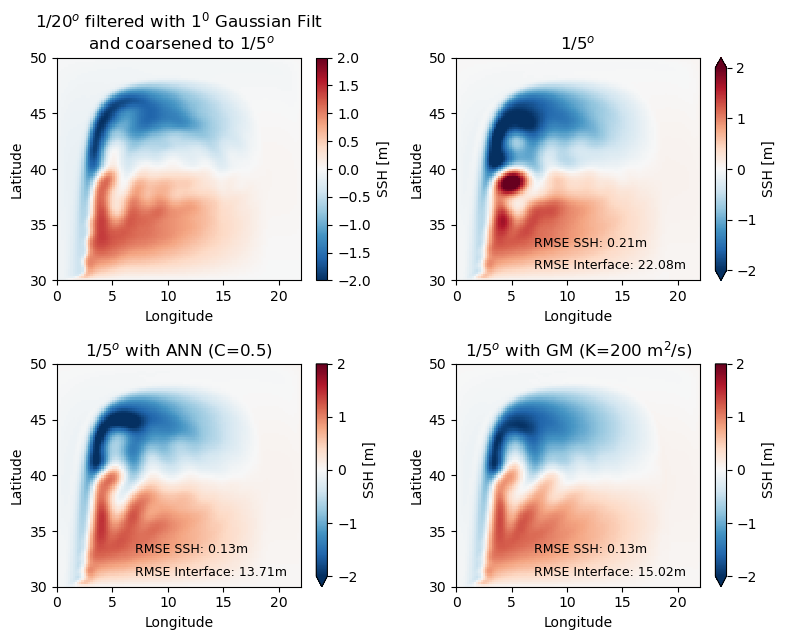

In [25]:
fig = plt.figure(figsize=(8, 6.5))

vmin = -2
zi = 0

# Panel 1
ax1 = plt.subplot(221)
e_mean_HR_coarse.isel(zi=zi).plot(ax=ax1, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax1.set_title('1/20$^o$ filtered with 1$^0$ Gaussian Filt \n and coarsened to 1/5$^o$')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Panel 2
ax2 = plt.subplot(222)
exp_tree['ANN']['20']['0.0']['ave_prog'].ave_e.isel(zi=zi).plot(ax=ax2, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax2.set_title('1/5$^o$')
ax2.text(7, 33, 'RMSE SSH: '+f"{err_LR_filt_coarse.values[0]:.2f}" + 'm',  fontsize=9)
ax2.text(7, 31, 'RMSE Interface: '+f"{err_LR_filt_coarse.values[1]:.2f}" + 'm',  fontsize=9)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Panel 3
ax3 = plt.subplot(223)
exp_tree['ANN']['20']['0.5']['ave_prog'].ave_e.isel(zi=zi).plot(ax=ax3, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax3.set_title('LR ANN C=0.5')
ax3.text(7, 33, 'RMSE SSH: '+f"{err_LR_ANN_filt_coarse.values[0]:.2f}" + 'm',  fontsize=9)
ax3.text(7, 31, 'RMSE Interface: '+f"{err_LR_ANN_filt_coarse.values[1]:.2f}" + 'm',  fontsize=9)
ax3.set_title('1/5$^o$ with ANN (C=0.5)')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Panel 4
ax4 = plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['ave_prog'].ave_e.isel(zi=zi).plot(ax=ax4, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax4.set_title('LR GM K=200')
ax4.text(7, 33, 'RMSE SSH: '+f"{err_LR_GM_filt_coarse.values[0]:.2f}" + 'm',  fontsize=9)
ax4.text(7, 31, 'RMSE Interface: '+f"{err_LR_GM_filt_coarse.values[1]:.2f}" + 'm',  fontsize=9)
ax4.set_title('1/5$^o$ with GM (K=200 m$^2$/s)')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

plt.tight_layout()

#plt.savefig('mean_SSH_DG.png')

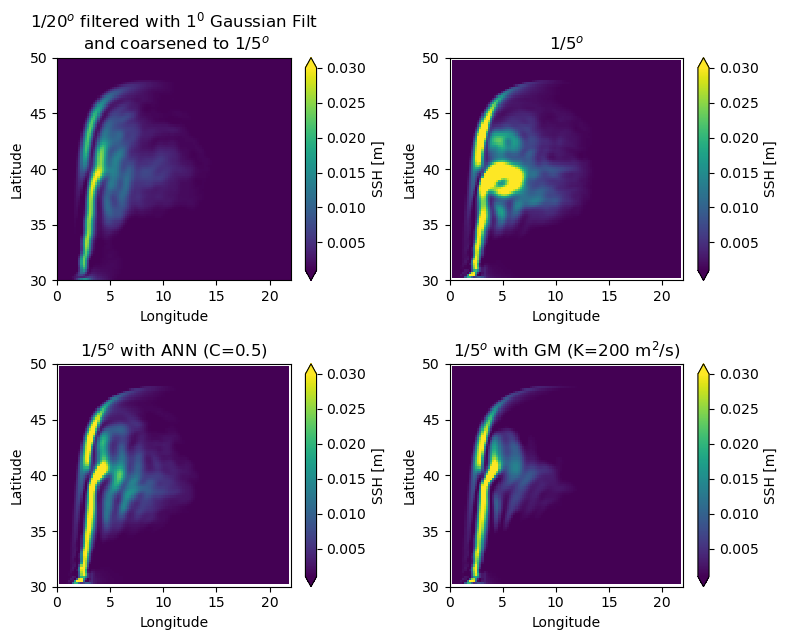

In [26]:
fig = plt.figure(figsize=(8, 6.5))

vmin = 1e-3
vmax = 3e-2
zl = 0

# Panel 1
ax1 = plt.subplot(221)
ds_filt_coarse.KE_map.isel(zl=zl).plot(ax=ax1, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax1.set_title('1/20$^o$ filtered with 1$^0$ Gaussian Filt \n and coarsened to 1/5$^o$')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Panel 2
ax2 = plt.subplot(222)
exp_tree['ANN']['20']['0.0']['prog'].KE_map.isel(zl=zl).plot(ax=ax2, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax2.set_title('1/5$^o$')
#ax2.text(7, 33, 'RMSE SSH: '+f"{err_LR.values[0]:.2f}" + 'm',  fontsize=9)
#ax2.text(7, 31, 'RMSE Interface: '+f"{err_LR.values[1]:.2f}" + 'm',  fontsize=9)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Panel 3
ax3 = plt.subplot(223)
exp_tree['ANN']['20']['0.5']['prog'].KE_map.isel(zl=zl).plot(ax=ax3, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax3.set_title('LR ANN C=0.5')
#ax3.text(7, 33, 'RMSE SSH: '+f"{err_LR_ANN.values[0]:.2f}" + 'm',  fontsize=9)
#ax3.text(7, 31, 'RMSE Interface: '+f"{err_LR_ANN.values[1]:.2f}" + 'm',  fontsize=9)
ax3.set_title('1/5$^o$ with ANN (C=0.5)')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Panel 4
ax4 = plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['prog'].KE_map.isel(zl=zl).plot(ax=ax4, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax4.set_title('LR GM K=200')
#ax4.text(7, 33, 'RMSE SSH: '+f"{err_LR_GM.values[0]:.2f}" + 'm',  fontsize=9)
#ax4.text(7, 31, 'RMSE Interface: '+f"{err_LR_GM.values[1]:.2f}" + 'm',  fontsize=9)
ax4.set_title('1/5$^o$ with GM (K=200 m$^2$/s)')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

plt.tight_layout()

#plt.savefig('mean_SSH_DG.png')

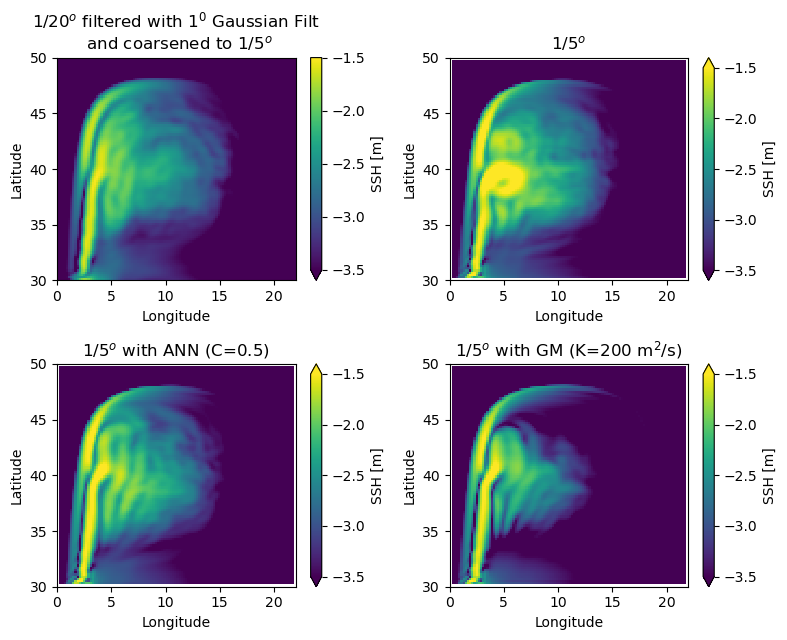

In [52]:
fig = plt.figure(figsize=(8, 6.5))

vmin = -3.5
vmax = -1.5
zl = 0

# Panel 1
ax1 = plt.subplot(221)
np.log10(ds_filt_coarse.KE_map).isel(zl=zl).plot(ax=ax1, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax1.set_title('1/20$^o$ filtered with 1$^0$ Gaussian Filt \n and coarsened to 1/5$^o$')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Panel 2
ax2 = plt.subplot(222)
np.log10(exp_tree['ANN']['20']['0.0']['prog'].KE_map).isel(zl=zl).plot(ax=ax2, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax2.set_title('1/5$^o$')
#ax2.text(7, 33, 'RMSE SSH: '+f"{err_LR.values[0]:.2f}" + 'm',  fontsize=9)
#ax2.text(7, 31, 'RMSE Interface: '+f"{err_LR.values[1]:.2f}" + 'm',  fontsize=9)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Panel 3
ax3 = plt.subplot(223)
np.log10(exp_tree['ANN']['20']['0.5']['prog'].KE_map).isel(zl=zl).plot(ax=ax3, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax3.set_title('LR ANN C=0.5')
#ax3.text(7, 33, 'RMSE SSH: '+f"{err_LR_ANN.values[0]:.2f}" + 'm',  fontsize=9)
#ax3.text(7, 31, 'RMSE Interface: '+f"{err_LR_ANN.values[1]:.2f}" + 'm',  fontsize=9)
ax3.set_title('1/5$^o$ with ANN (C=0.5)')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Panel 4
ax4 = plt.subplot(224)
np.log10(exp_tree['GM1000']['20']['0.2']['prog'].KE_map).isel(zl=zl).plot(ax=ax4, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax4.set_title('LR GM K=200')
#ax4.text(7, 33, 'RMSE SSH: '+f"{err_LR_GM.values[0]:.2f}" + 'm',  fontsize=9)
#ax4.text(7, 31, 'RMSE Interface: '+f"{err_LR_GM.values[1]:.2f}" + 'm',  fontsize=9)
ax4.set_title('1/5$^o$ with GM (K=200 m$^2$/s)')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

plt.tight_layout()

#plt.savefig('mean_SSH_DG.png')

In [ ]:
fig = plt.figure(figsize=(8, 6.5))

vmin = 1e-3
vmax = 3e-2
zl = 0

# Panel 1
ax1 = plt.subplot(221)
ds_filt_coarse.KE_map.isel(zl=zl).plot(ax=ax1, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax1.set_title('1/20$^o$ filtered with 1$^0$ Gaussian Filt \n and coarsened to 1/5$^o$')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Panel 2
ax2 = plt.subplot(222)
exp_tree['ANN']['20']['0.0']['prog'].KE_map.isel(zl=zl).plot(ax=ax2, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax2.set_title('1/5$^o$')
#ax2.text(7, 33, 'RMSE SSH: '+f"{err_LR.values[0]:.2f}" + 'm',  fontsize=9)
#ax2.text(7, 31, 'RMSE Interface: '+f"{err_LR.values[1]:.2f}" + 'm',  fontsize=9)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Panel 3
ax3 = plt.subplot(223)
exp_tree['ANN']['20']['0.5']['prog'].KE_map.isel(zl=zl).plot(ax=ax3, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax3.set_title('LR ANN C=0.5')
#ax3.text(7, 33, 'RMSE SSH: '+f"{err_LR_ANN.values[0]:.2f}" + 'm',  fontsize=9)
#ax3.text(7, 31, 'RMSE Interface: '+f"{err_LR_ANN.values[1]:.2f}" + 'm',  fontsize=9)
ax3.set_title('1/5$^o$ with ANN (C=0.5)')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Panel 4
ax4 = plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['prog'].KE_map.isel(zl=zl).plot(ax=ax4, vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'SSH [m]'})
ax4.set_title('LR GM K=200')
#ax4.text(7, 33, 'RMSE SSH: '+f"{err_LR_GM.values[0]:.2f}" + 'm',  fontsize=9)
#ax4.text(7, 31, 'RMSE Interface: '+f"{err_LR_GM.values[1]:.2f}" + 'm',  fontsize=9)
ax4.set_title('1/5$^o$ with GM (K=200 m$^2$/s)')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

plt.tight_layout()

#plt.savefig('mean_SSH_DG.png')

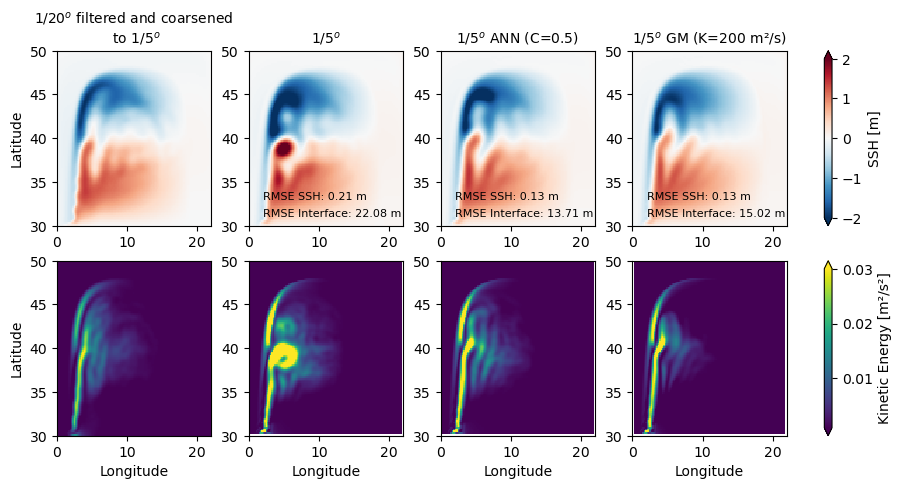

In [44]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.3, hspace=0.2)

# --- Settings ---
zi = 0
zl = 0

# SSH
vmin1 = -2
vmax1 = 2
cbar_label1 = 'SSH [m]'

# KE
vmin2 = 1e-3
vmax2 = 3e-2
cbar_label2 = 'Kinetic Energy [m²/s²]'

titles = [
    '1/20$^o$ filtered and coarsened \n to 1/5$^o$',
    '1/5$^o$',
    '1/5$^o$ ANN (C=0.5)',
    '1/5$^o$ GM (K=200 m²/s)'
]

# --- Top row data and RMSE ---
top_data = [
    e_mean_HR_coarse.isel(zi=zi),
    exp_tree['ANN']['20']['0.0']['ave_prog'].ave_e.isel(zi=zi),
    exp_tree['ANN']['20']['0.5']['ave_prog'].ave_e.isel(zi=zi),
    exp_tree['GM1000']['20']['0.2']['ave_prog'].ave_e.isel(zi=zi),
]

top_errors = [
    err_LR_filt_coarse,
    err_LR_filt_coarse,
    err_LR_ANN_filt_coarse,
    err_LR_GM_filt_coarse,
]

# --- Bottom row data ---
bottom_data = [
    ds_filt_coarse.KE_map.isel(zl=zl),
    exp_tree['ANN']['20']['0.0']['prog'].KE_map.isel(zl=zl),
    exp_tree['ANN']['20']['0.5']['prog'].KE_map.isel(zl=zl),
    exp_tree['GM1000']['20']['0.2']['prog'].KE_map.isel(zl=zl),
]

# === Top row: SSH ===
for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    p1 = top_data[i].plot(
        ax=ax, vmin=vmin1, vmax=vmax1, cmap='RdBu_r',
        add_colorbar=False
    )
    ax.set_title(titles[i], fontsize=10)
    if i ==0:
        ax.set_ylabel('Latitude')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('')
    if i>0:
        ax.text(2, 33, f"RMSE SSH: {top_errors[i].values[0]:.2f} m", fontsize=8, color='k')
        ax.text(2, 31, f"RMSE Interface: {top_errors[i].values[1]:.2f} m", fontsize=8, color='k')

# === Colorbar for SSH ===
cax1 = fig.add_subplot(gs[0, 4])
cbar1 = fig.colorbar(p1, cax=cax1, extend='both')
cbar1.set_label(cbar_label1)

# === Bottom row: KE ===
for i in range(4):
    ax = fig.add_subplot(gs[1, i])
    p2 = bottom_data[i].plot(
        ax=ax, vmin=vmin2, vmax=vmax2, cmap='viridis',
        add_colorbar=False
    )
    #ax.set_title(titles[i], fontsize=10)
    ax.set_title('')
    if i==0:
        ax.set_ylabel('Latitude')
    else:
        ax.set_ylabel('')
    
    ax.set_xlabel('Longitude')

# === Colorbar for KE ===
cax2 = fig.add_subplot(gs[1, 4])
cbar2 = fig.colorbar(p2, cax=cax2, extend='both')
cbar2.set_label(cbar_label2)

# Optional save
fig.savefig('mean_SSH_KE_combined.png', dpi=300, bbox_inches='tight')

#plt.show()


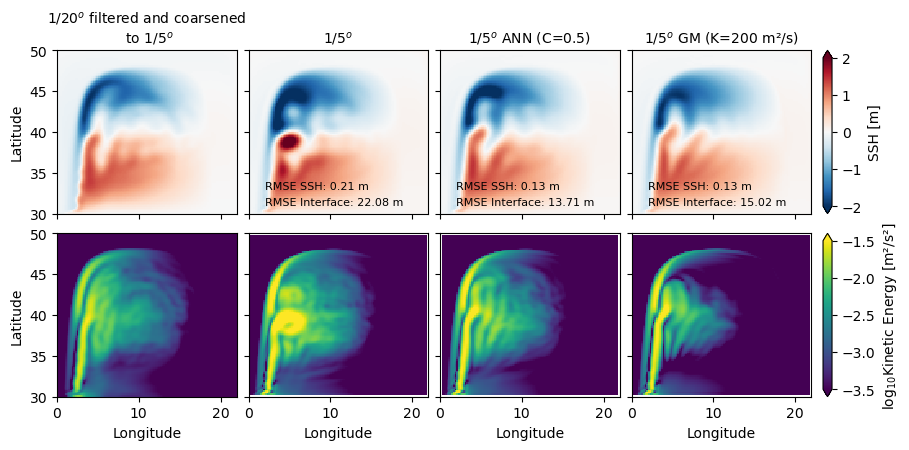

In [70]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 4.5))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.05], 
                       wspace=0.08, hspace=0.12)

# --- Settings ---
zi = 0
zl = 0

# SSH
vmin1 = -2
vmax1 = 2
cbar_label1 = 'SSH [m]'

# KE
vmin2 = -3.5
vmax2 = -1.5
cbar_label2 = 'log$_{10} $Kinetic Energy [m²/s²]'

titles = [
    '1/20$^o$ filtered and coarsened \n to 1/5$^o$',
    '1/5$^o$',
    '1/5$^o$ ANN (C=0.5)',
    '1/5$^o$ GM (K=200 m²/s)'
]

# --- Top row data and RMSE ---
top_data = [
    e_mean_HR_coarse.isel(zi=zi),
    exp_tree['ANN']['20']['0.0']['ave_prog'].ave_e.isel(zi=zi),
    exp_tree['ANN']['20']['0.5']['ave_prog'].ave_e.isel(zi=zi),
    exp_tree['GM1000']['20']['0.2']['ave_prog'].ave_e.isel(zi=zi),
]

top_errors = [
    err_LR_filt_coarse,
    err_LR_filt_coarse,
    err_LR_ANN_filt_coarse,
    err_LR_GM_filt_coarse,
]

# --- Bottom row data ---
bottom_data = [
    np.log10(ds_filt_coarse.KE_map).isel(zl=zl),
    np.log10(exp_tree['ANN']['20']['0.0']['prog'].KE_map).isel(zl=zl),
    np.log10(exp_tree['ANN']['20']['0.5']['prog'].KE_map).isel(zl=zl),
    np.log10(exp_tree['GM1000']['20']['0.2']['prog'].KE_map).isel(zl=zl),
]

# === Top row: SSH ===
for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    p1 = top_data[i].plot(
        ax=ax, vmin=vmin1, vmax=vmax1, cmap='RdBu_r',
        add_colorbar=False
    )
    ax.set_title(titles[i], fontsize=10)
    if i ==0:
        ax.set_ylabel('Latitude')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
    if i>0:
        ax.text(2, 33, f"RMSE SSH: {top_errors[i].values[0]:.2f} m", fontsize=8, color='k')
        ax.text(2, 31, f"RMSE Interface: {top_errors[i].values[1]:.2f} m", fontsize=8, color='k')

# === Colorbar for SSH ===
cax1 = fig.add_subplot(gs[0, 4])
cbar1 = fig.colorbar(p1, cax=cax1, extend='both')
cbar1.set_label(cbar_label1)

# === Bottom row: KE ===
for i in range(4):
    ax = fig.add_subplot(gs[1, i])
    p2 = bottom_data[i].plot(
        ax=ax, vmin=vmin2, vmax=vmax2, cmap='viridis',
        add_colorbar=False
    )
    #ax.set_title(titles[i], fontsize=10)
    ax.set_title('')
    if i==0:
        ax.set_ylabel('Latitude')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    
    ax.set_xlabel('Longitude')

# === Colorbar for KE ===
cax2 = fig.add_subplot(gs[1, 4])
cbar2 = fig.colorbar(p2, cax=cax2, extend='both')
cbar2.set_label(cbar_label2)

# Optional save
fig.savefig('mean_SSH_logKE_combined.png', dpi=300, bbox_inches='tight')

#plt.show()


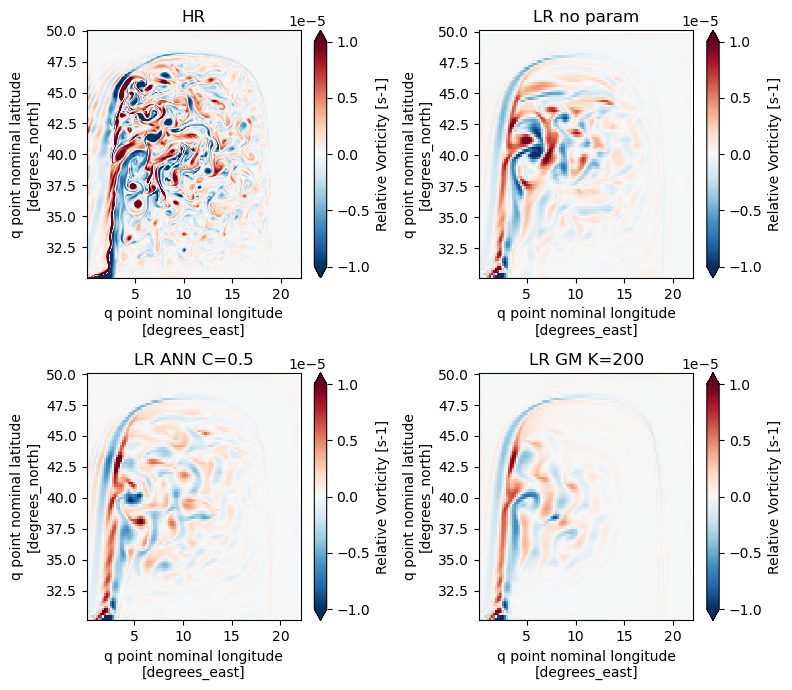

In [38]:
plt.figure(figsize=(8, 7))

vmin=-1e-5
zl = 0

plt.subplot(221)
ds_HR['prog'].RV.isel(Time=-1, zl=zl).plot(vmin = vmin)
plt.title('HR')

plt.subplot(222)
exp_tree['ANN']['20']['0.0']['prog'].RV.isel(Time=-1, zl=zl).plot(vmin=vmin)
plt.title('LR no param')

plt.subplot(223)
exp_tree['ANN']['20']['0.5']['prog'].RV.isel(Time=-1, zl=zl).plot(vmin=vmin)
plt.title('LR ANN C=0.5')

plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['prog'].RV.isel(Time=-1, zl=zl).plot(vmin=vmin)
plt.title('LR GM K=200')

plt.tight_layout()

## Plots KE and APE

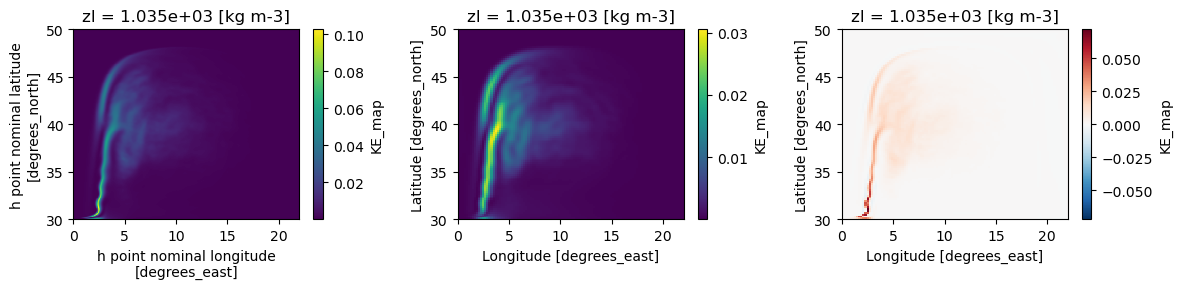

In [43]:
plt.figure(figsize=(12, 3))

zl=0

plt.subplot(131)
ds_HR['prog'].KE_map.isel(zl=zl).plot()

plt.subplot(132)
ds_filt_coarse.KE_map.isel(zl=zl).plot()

plt.subplot(133)
xh_lr = ds_filt_coarse.xh
yh_lr = ds_filt_coarse.yh
(ds_HR['prog'].KE_map.interp(xh=xh_lr, yh=yh_lr) - ds_filt_coarse.KE_map).isel(zl=zl).plot()


plt.tight_layout()

In [56]:
exp_ds = [ds_HR['prog'], 
          ds_filt_coarse, 
          exp_tree['ANN']['20']['0.0']['prog'],
          exp_tree['ANN']['20']['0.5']['prog'],
          exp_tree['GM1000']['20']['0.2']['prog']]


MKE = np.zeros(len(exp_ds))
EKE = np.zeros(len(exp_ds))
MKE_SubFilter = np.zeros(len(exp_ds))
EKE_SubFilter = np.zeros(len(exp_ds))

MAPE = np.zeros(len(exp_ds))
EAPE = np.zeros(len(exp_ds))
MAPE_SubFilter = np.zeros(len(exp_ds))
EAPE_SubFilter = np.zeros(len(exp_ds))

for i, ds in enumerate(exp_ds):
    print(i)
    MKE[i] = ds['MKE'].values
    EKE[i] = ds['EKE'].sel(Time=Tsel).mean('Time').values

    
    MAPE[i] = ds['MAPE'].values
    EAPE[i] = ds['EAPE'].sel(Time=Tsel).mean('Time').values
    

EKE_SubFilter[1] = (EKE[0] - EKE[1])  
MKE_SubFilter[1] = (MKE[0] - MKE[1]) 
EAPE_SubFilter[1] = (EAPE[0] - EAPE[1])  
MAPE_SubFilter[1] = (MAPE[0] - MAPE[1])

0
1
2
3
4


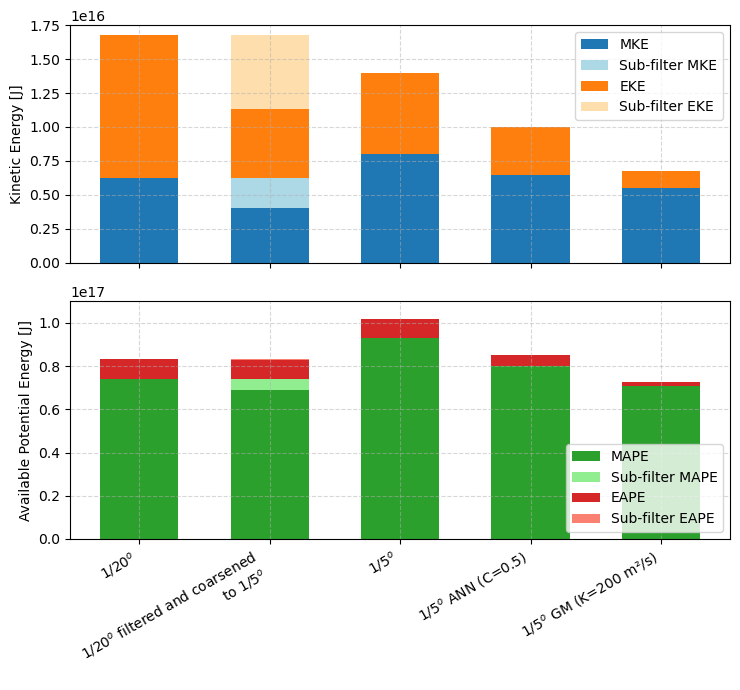

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Experiment labels
exp_names = [
    '1/20$^o$',
    '1/20$^o$ filtered and coarsened\nto 1/5$^o$',
    '1/5$^o$',
    '1/5$^o$ ANN (C=0.5)',
    '1/5$^o$ GM (K=200 m²/s)'
]

x = np.arange(len(exp_names))
bar_width = 0.6

fig, axes = plt.subplots(2, 1, figsize=(7.5, 7), sharex=True)

# --- KE Panel ---
axes[0].bar(x, MKE, bar_width, label='MKE', color='tab:blue')
axes[0].bar(x, MKE_SubFilter, bar_width, bottom=MKE, label='Sub-filter MKE', color='lightblue')
axes[0].bar(x, EKE, bar_width, bottom=MKE+MKE_SubFilter, label='EKE', color='tab:orange')
axes[0].bar(x, EKE_SubFilter, bar_width, bottom=MKE+MKE_SubFilter+EKE, label='Sub-filter EKE', color='navajowhite')

axes[0].set_ylabel('Kinetic Energy [J]')
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_ylim([0, 1.75e16])
#axes[0].set_title('Kinetic Energy Budget')

# --- APE Panel ---
axes[1].bar(x, MAPE, bar_width, label='MAPE', color='tab:green')
axes[1].bar(x, MAPE_SubFilter, bar_width, bottom=MAPE, label='Sub-filter MAPE', color='lightgreen')
axes[1].bar(x, EAPE, bar_width, bottom=MAPE+MAPE_SubFilter, label='EAPE', color='tab:red')
axes[1].bar(x, EAPE_SubFilter, bar_width, bottom=MAPE+MAPE_SubFilter+EAPE, label='Sub-filter EAPE', color='salmon')

axes[1].set_ylabel('Available Potential Energy [J]')
axes[1].legend(loc='lower right')
axes[1].grid(True, linestyle='--', alpha=0.5)
#axes[1].set_title('Available Potential Energy Budget')

# Shared x-axis labels
axes[1].set_xticks(x)
axes[1].set_xticklabels(exp_names, rotation=30, ha='right')
axes[1].set_ylim([0, 1.1e17])

# Layout and save
plt.tight_layout()

# Optional: save with high resolution for publication
plt.savefig('energy_budget_DG.png', dpi=300, bbox_inches='tight')

#plt.show()


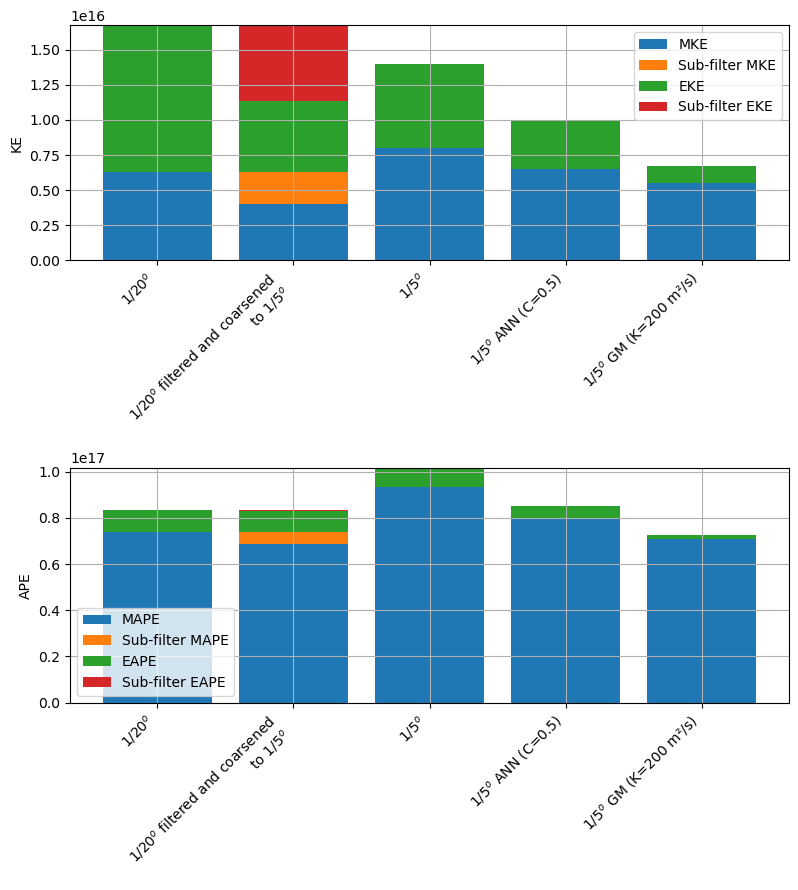

In [59]:
#exp_names = ['4 km',  '4 km, filt', '20km', '20 km, ANN=0.5', '20km, GM=200']

exp_names = [
    '1/20$^o$',
    '1/20$^o$ filtered and coarsened \n to 1/5$^o$',
    '1/5$^o$',
    '1/5$^o$ ANN (C=0.5)',
    '1/5$^o$ GM (K=200 m²/s)'
]

# Create the stacked bar plot
fig, ax = plt.subplots(2,1, figsize=(8, 9))

x = np.arange(len(exp_names))

# Plot the resolved part (bottom)
ax[0].bar(x, MKE, label='MKE')

# Plot the param part (stacked on top)
ax[0].bar(x, MKE_SubFilter, bottom=MKE, label='Sub-filter MKE')

# Plot the param part (stacked on top)
ax[0].bar(x, EKE, bottom=MKE+MKE_SubFilter, label='EKE')


ax[0].bar(x, EKE_SubFilter, bottom=MKE+EKE+MKE_SubFilter, label='Sub-filter EKE')


# Labeling
ax[0].set_xticks(x)
ax[0].set_xticklabels(exp_names, rotation=45, ha='right')
ax[0].set_ylabel('KE')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax[0].legend()

#ax[0].set_ylim(0, 1.3e17)
ax[0].grid()


# Plot the resolved part (bottom)
ax[1].bar(x, MAPE, label='MAPE')

# Plot the param part (stacked on top)
ax[1].bar(x, MAPE_SubFilter, bottom=MAPE, label='Sub-filter MAPE')


# Plot the param part (stacked on top)
ax[1].bar(x, EAPE, bottom=MAPE+MAPE_SubFilter, label='EAPE')

# Plot the param part (stacked on top)
ax[1].bar(x, EAPE_SubFilter, bottom=MAPE+MAPE_SubFilter+EAPE, label='Sub-filter EAPE')


# Labeling
ax[1].set_xticks(x)
ax[1].set_xticklabels(exp_names, rotation=45, ha='right')
ax[1].set_ylabel('APE')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax[1].legend()

#ax[1].set_ylim(1.1e18, 1.4e18)
ax[1].grid()

plt.tight_layout()

#plt.savefig('energy_levels_DG.png')

## APE reduction rates 

In [12]:
exp_tree = exp_tree.map_over_subtree(sam.add_PE_reduction_rate_map)

In [13]:
ds_filt_coarse = sam.add_PE_reduction_rate_map(ds_filt_coarse, Fvar=['uphp','vphp'])

In [14]:
exp_tree = exp_tree.map_over_subtree(sam.add_PE_reduction_rate)

In [15]:
ds_filt_coarse = sam.add_PE_reduction_rate(ds_filt_coarse, Fvar=['uphp','vphp'])

In [20]:
int_filt_coarse_APE_rate_mean = ds_filt_coarse.APE_reduce_rate_mean_bulk.values
int_ANN_APE_rate_mean = exp_tree['ANN']['20']['0.5']['prog'].APE_reduce_rate_mean_bulk.values
int_GM_APE_rate_mean = exp_tree['GM1000']['20']['0.2']['prog'].APE_reduce_rate_mean_bulk.values

In [22]:
int_filt_coarse_APE_rate_eddy = ds_filt_coarse.APE_reduce_rate_eddy_bulk.values
int_ANN_APE_rate_eddy = exp_tree['ANN']['20']['0.5']['prog'].APE_reduce_rate_eddy_bulk.values
int_GM_APE_rate_eddy = exp_tree['GM1000']['20']['0.2']['prog'].APE_reduce_rate_eddy_bulk.values

In [23]:
print(int_filt_coarse_APE_rate_mean, int_ANN_APE_rate_mean)

-358091191.1726439 -1144752229.2207382


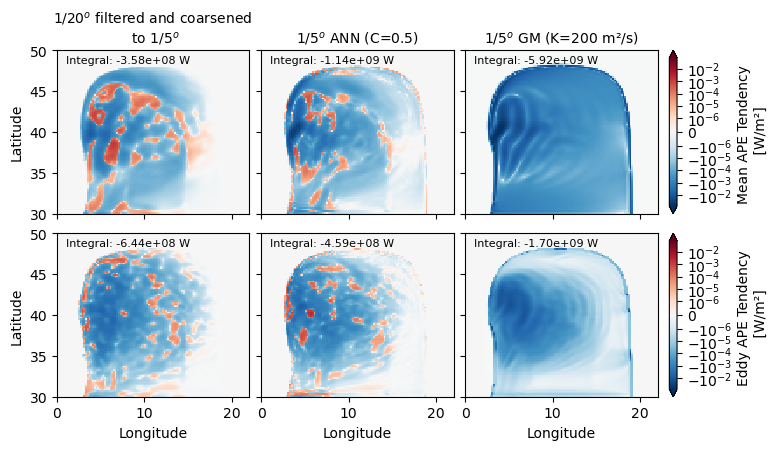

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib.gridspec as gridspec
import numpy as np

# --- User option ---
use_symlog = True

vmax = 8e-2
vmin = -vmax
linthresh = 1e-6

norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax) if use_symlog else None
cmap = 'RdBu_r'

# Column titles
col_titles = [
    '1/20$^o$ filtered and coarsened \n to 1/5$^o$',
    '1/5$^o$ ANN (C=0.5)',
    '1/5$^o$ GM (K=200 m²/s)'
]

# Data arrays
data_top = [
    ds_filt_coarse['APE_reduce_rate_mean'],
    exp_tree['ANN']['20']['0.5']['prog']['APE_reduce_rate_mean'],
    exp_tree['GM1000']['20']['0.2']['prog']['APE_reduce_rate_mean']
]

data_bottom = [
    ds_filt_coarse['APE_reduce_rate_eddy'],
    exp_tree['ANN']['20']['0.5']['prog']['APE_reduce_rate_eddy'],
    exp_tree['GM1000']['20']['0.2']['prog']['APE_reduce_rate_eddy']
]

int_top = [int_filt_coarse_APE_rate_mean,
           int_ANN_APE_rate_mean,
           int_GM_APE_rate_mean]

int_bottom = [int_filt_coarse_APE_rate_eddy,
           int_ANN_APE_rate_eddy,
           int_GM_APE_rate_eddy]

# === Layout using gridspec ===
fig = plt.figure(figsize=(8, 4.5))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=[1, 1, 1, 0.04], wspace=0.08, hspace=0.12)

# --- Top row (mean) ---
for i, da in enumerate(data_top):
    ax = fig.add_subplot(gs[0, i])
    p = da.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, add_colorbar=False)
    ax.set_title(col_titles[i], fontsize=10)
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.text(1,48.4, f"Integral: {int_top[i]:.2e} W", fontsize=8, color='k')
    if i==0:
        ax.set_ylabel('Latitude')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        
# Colorbar (right of top row)
cax1 = fig.add_subplot(gs[0, 3])
cbar1 = fig.colorbar(p, cax=cax1, extend='both')
cbar1.set_label('Mean APE Tendency \n [W/m²]')

# --- Bottom row (eddy) ---
for i, da in enumerate(data_bottom):
    ax = fig.add_subplot(gs[1, i])
    p = da.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, add_colorbar=False)
    
    ax.set_xlabel('Longitude')
    ax.text(1,48.4, f"Integral: {int_bottom[i]:.2e} W", fontsize=8, color='k')
    if i==0:
        ax.set_ylabel('Latitude')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

# Colorbar (right of bottom row)
cax2 = fig.add_subplot(gs[1, 3])
cbar2 = fig.colorbar(p, cax=cax2, extend='both')
cbar2.set_label('Eddy APE Tendency \n [W/m²]')

# Optional: save for print
fig.savefig('APE_tend_DG.png', dpi=300, bbox_inches='tight')

# fig.savefig('APE_reduction_symlog_rightCB.pdf', dpi=300, bbox_inches='tight', transparent=True)

#plt.show()
